# BHL accretion with finite refill time

This is an implementation of section 6 of my paper, where I consider the reduction in the effective accretion area due to the finite time reauired for the wind to refill the accretion torus. 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.optimize import fsolve
sns.set_context("notebook")

## Torus refill functions

In [2]:
def r_bhl(q, w):
    """Classical Hoyle–Lyttleton radius

    In units of a
    """
    return 2 * q / (1 + w**2)

def f_linear(q, w):
    """Fraction of torus thickness refilled by wind in one orbital period

    This is f from equation (21) of paper

    Assumes that accretion radius is the BHL value
    """
    return np.pi * w * (1 + w**2)**1.5 / (2 * q)
    # return np.where(
    #     w < 1,
    #     np.pi * w * (1 + w**2)**1.5 / (2 * q),
    #     1
    # )

def F_area(f):
    """Fraction of torus area refilled by wind in one orbital period

    In terms of the linear diameter fraction f
    """
    return (
        1 -
        (2 / np.pi) * (
            np.arccos(f) - f * np.sqrt(1 - f**2)
        )
    )
    
    

### Test the area function 

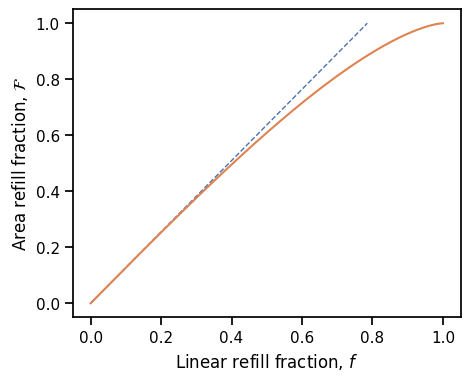

In [3]:
sns.set_palette("deep")
fig, ax = plt.subplots(figsize=(5, 4))
fgrid = np.linspace(0, 1, 200)
ax.plot([0, np.pi/4], [0, 1], ls="dashed", lw=1)
ax.plot(fgrid, F_area(fgrid))
ax.set(
    xlabel="Linear refill fraction, $f$",
    ylabel=r"Area refill fraction, $\mathcal{F}$",
)
fig.savefig("refill-fraction.pdf", bbox_inches="tight")
...;

As function of binary parameters

In [4]:
np.seterr(all="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

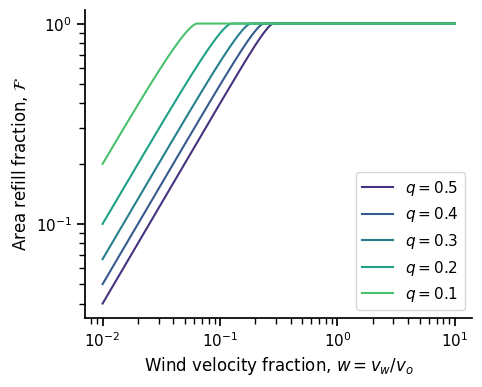

In [5]:
sns.set_palette(sns.mpl_palette("viridis"))
fig, ax = plt.subplots(figsize=(5, 4))
wgrid = np.geomspace(0.01, 10, 200)

for q in reversed([0.1, 0.2, 0.3, 0.4, 0.5]):
    f = f_linear(q, wgrid)
    ax.plot(wgrid, np.where(f < 1, F_area(f), 1),
           label=f"$q = {q}$",
           )
ax.legend()
ax.set(
    xlabel="Wind velocity fraction, $w = v_w / v_o$",
    ylabel=r"Area refill fraction, $\mathcal{F}$",
    xscale="log",
    yscale="log",
)
sns.despine()
...;

## Affect on accretion efficiency



In [6]:
def vr_over_vw(w):
    """Ratio v_r / v_w 
    
    Ratio of aberrated wind velocity in frame of secondary

        v_r = sqrt(v_w**2 + v_o**2)
        
    to the wind velocity in frame of primary, v_w. 

    Parameter w is v_w / v_o where v_o is orbital speed
    """
    return np.sqrt(1 + w**2) / w

def eta_bhl(q, w):
    """Accretion efficiency"""
    rsq = r_bhl(q, w) ** 2
    return rsq * vr_over_vw(w) / 4

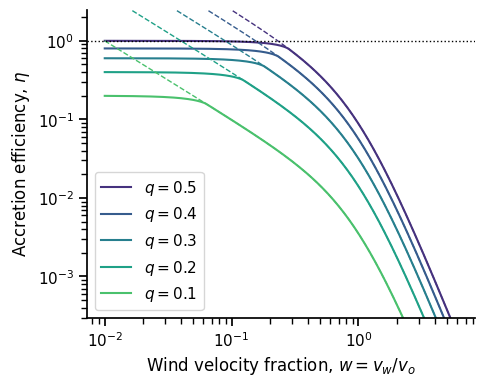

In [7]:
sns.set_palette(sns.mpl_palette("viridis"))

fig, ax = plt.subplots(figsize=(5, 4))
wgrid = np.geomspace(0.01, 6, 200)

for q in reversed([0.1, 0.2, 0.3, 0.4, 0.5]):
    
    f = f_linear(q, wgrid)
    eta0 = eta_bhl(q, wgrid)
    line, = ax.plot(
        wgrid, np.where(f < 1, F_area(f) * eta0, eta0),
        label=f"$q = {q}$",
        )
    ax.plot(
        wgrid,
        eta0,
        ls="dashed",
        lw=1,
        color=line.get_color(),
    )
ax.legend()
ax.axhline(1.0, ls="dotted", color="k", lw=1)
ax.set(
    xlabel="Wind velocity fraction, $w = v_w / v_o$",
    ylabel=r"Accretion efficiency, $\eta$",
    xscale="log",
    yscale="log",
    ylim=[0.3e-3, 2.5],
)
sns.despine()
fig.savefig("eta-finite-refill.pdf", bbox_inches="tight")
...;

So this shows the effect of the starvation on the accretion, but that only becomes important for $w < 0.2$ or so.


## Rewrite explicitly in terms of accretion radius

In order to reuse this with the Roche case, we need to unpack the equations a bit so we can see exactly how it depends on the accretion radius, which is different from the HL radius in that case. 

In [8]:
def flinear_racc(racc, q, w):
    """Linear refill fraction in terms of accretion radius"""
    h = 2 * racc / np.sqrt(1 + w**2)
    x = 2 * np.pi * w
    return x / h

Test that it gives the same answer with the BHL radius

In [9]:
q = 0.5; w = 0.2
f_linear(q, w), flinear_racc(r_bhl(q, w), q, w)

(0.6663921573676264, np.float64(0.6663921573676264))

It is good that I did that, since it brought to light an error in my original implementation of `f_linear()`